In [22]:
import numpy as np 
import pandas as pd
import math as math
import random
import time

from keras.layers import Input, Dense
from keras.models import Model

import tensorflow as tf

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from triplet_encoding import *
from shared_module import *

from IPython.display import display

# Hyperparameters
- N_ANCHORS determines the number of anchors we find for each breed
- ENCODING_STRATEGY dictates the image encoding model and the size of the input vector

In [2]:
N_ANCHORS = ANCHORS_12
ENCODING_STRATEGY = VGG19_4096
ENCODING_SIZE = 4096

random.seed()

## Load the pre-processed training file. The training file already contains the anchors and cluster information.


In [3]:
INPUT_FILE_PATH = './input/labels'

training_file_path = get_path(INPUT_FILE_PATH, N_ANCHORS, ENCODING_STRATEGY)

df_train = pd.read_csv(training_file_path('anchor'))



### Statistics about the breeds in dataset

In [4]:
display(df_train.groupby(['breed']).agg(['count']))

,id,encoding,anp,cluster
,count,count,count,count
breed,,,,
affenpinscher,80,80,80,80
afghan_hound,116,116,116,116
african_hunting_dog,86,86,86,86
airedale,107,107,107,107
american_staffordshire_terrier,74,74,74,74
appenzeller,78,78,78,78
australian_terrier,102,102,102,102
basenji,110,110,110,110


### Breeds and sample of pictures

'total number of breeds 120'

miniature_pinscher


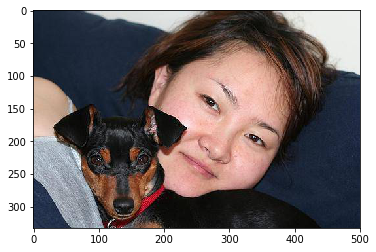

eskimo_dog


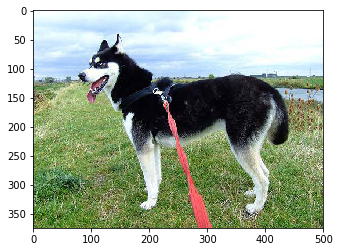

In [5]:
breeds = df_train['breed'].unique()

display('total number of breeds ' + str(len(breeds)))


def sample_by_breed(df_train):
    breeds = df_train['breed'].unique()
    random.seed()
    breed = breeds[random.randint(0, len(breeds) - 1)]
    df_breed = df_train.loc[(df_train['breed'] == breed)]
    random_index = random.randint(0, (df_breed.shape[0] - 1))
    print(breed)
    show_img(df_breed.iloc[random_index].id)

    
def show_img(image_id):
    img = Image.open(IMAGE_DIR + '/{name}.jpg'.format(name=image_id))
    plt.imshow(img)
    plt.show()

    
sample_by_breed(df_train)
sample_by_breed(df_train)

## Load the pre-processed triplets training file
## Shuffle the triplets so that we don't just train all of a single breed first 

In [6]:
def shuffle_triplets(df_triplets):
    return df_triplets.sample(frac=1).reset_index(drop=True)

df_triplets = pd.read_csv(training_file_path('triplets'))

df_triplets = shuffle_triplets(df_triplets)
display('Total number of triplets ' + str(df_triplets.shape[0]))

display(df_triplets.head())

'Total number of triplets 2056320'

,anchor_id,anchor_type,anchor_encoding,positive_id,positive_type,positive_encoding,negative_id,negative_type,negative_encoding
0,c62d6c163cbe1109462aa729bc4f425c,chesapeake_bay_retriever,./input/vgg19_4096/c62d6c163cbe1109462aa729bc4...,6fdb5f8b4439dbeac3781c0e2fef4997,chesapeake_bay_retriever,./input/vgg19_4096/6fdb5f8b4439dbeac3781c0e2fe...,d91689717c8333406434d3511990958d,briard,./input/vgg19_4096/d91689717c8333406434d351199...
1,811285f3b3d19c883f18e8afc0e19e29,english_springer,./input/vgg19_4096/811285f3b3d19c883f18e8afc0e...,3e42bccc11b30acce650a703caa33c98,english_springer,./input/vgg19_4096/3e42bccc11b30acce650a703caa...,0c4ac597d196aaf07f3af039b8fd6925,vizsla,./input/vgg19_4096/0c4ac597d196aaf07f3af039b8f...
2,f751bb00d954b8e4e132c958e7117011,boxer,./input/vgg19_4096/f751bb00d954b8e4e132c958e71...,14d2892358ea21837f7a9399c0b00acb,boxer,./input/vgg19_4096/14d2892358ea21837f7a9399c0b...,a23f53a45ee2d6d6218c7e3b70234091,boston_bull,./input/vgg19_4096/a23f53a45ee2d6d6218c7e3b702...
3,d42994838dea65d1516398fe86ff80be,otterhound,./input/vgg19_4096/d42994838dea65d1516398fe86f...,cb26e46dc1578cb8816f6e5e24a070e0,otterhound,./input/vgg19_4096/cb26e46dc1578cb8816f6e5e24a...,89962510e8e4ad50a1de642bf49945df,pomeranian,./input/vgg19_4096/89962510e8e4ad50a1de642bf49...
4,5cf7a6e59deee02173bb24459d197e06,american_staffordshire_terrier,./input/vgg19_4096/5cf7a6e59deee02173bb24459d1...,6eaa58eb9a9f96c8474607b72387c91e,american_staffordshire_terrier,./input/vgg19_4096/6eaa58eb9a9f96c8474607b7238...,c6f47117753a8f83c93ad62369c7266b,appenzeller,./input/vgg19_4096/c6f47117753a8f83c93ad62369c...


### Show samples of the triplets

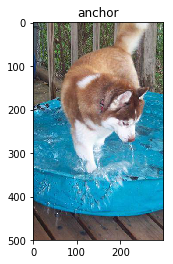

./input/train-2/c59c717f3f699529820090cd02563faa.jpg
siberian_husky


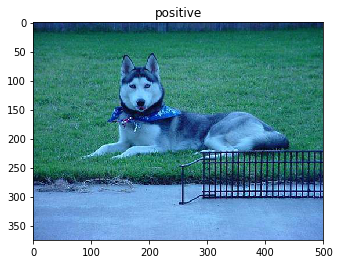

./input/train-2/3d180d390b32baf36478bc8599b3d8fc.jpg
siberian_husky


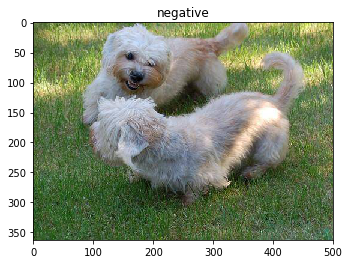

./input/train-2/8403d8936430c2f05ab7d74d23c2c0cb.jpg
dandie_dinmont


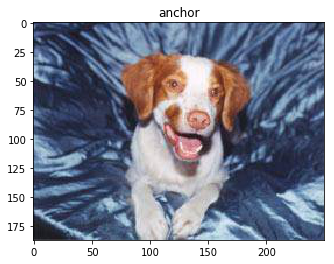

./input/train-2/83be6d622ab74a5e7e08b53eb8fd566a.jpg
brittany_spaniel


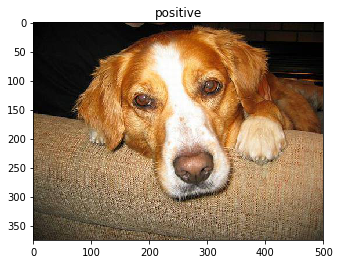

./input/train-2/c91b930254bb79924d90086f3353a8ab.jpg
brittany_spaniel


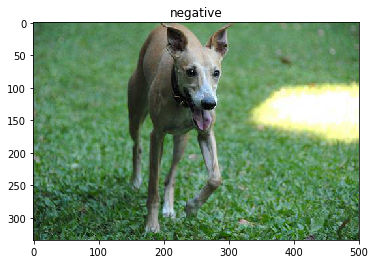

./input/train-2/fca387fcb6630ae11536b3374d3b2234.jpg
whippet


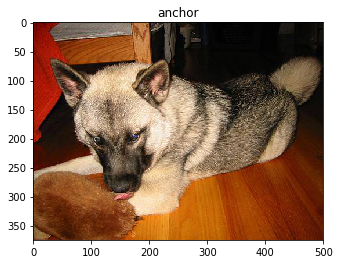

./input/train-2/6930f2a5b07417d227aaf2b05917bbdc.jpg
norwegian_elkhound


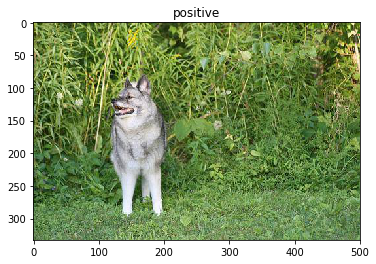

./input/train-2/0140b05bfc2fd43f2819fab3d8566109.jpg
norwegian_elkhound


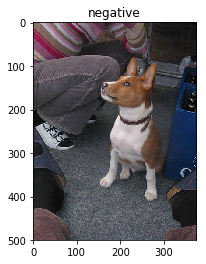

./input/train-2/06faa041b335551e3ccf3c239d006425.jpg
basenji


In [7]:
def show_triplets(df_triplets):
    row = df_triplets.iloc[random.randint(0, df_triplets.shape[0]-1)]
    anchor_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['anchor_id'])
    img = Image.open(anchor_path)
    plt.imshow(img)
    plt.title('anchor')
    plt.show()
    print(anchor_path)
    print(row['anchor_type'])
    positive_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['positive_id'])
    img = Image.open(positive_path)
    plt.imshow(img)
    plt.title('positive')
    plt.show()
    print(positive_path)
    print(row['positive_type'])
    negative_path = IMAGE_DIR + '/{name}.jpg'.format(name=row['negative_id'])
    img = Image.open(negative_path)
    plt.imshow(img)
    plt.title('negative')
    plt.show()
    print(negative_path)
    print(row['negative_type'])

show_triplets(df_triplets)
show_triplets(df_triplets)
show_triplets(df_triplets)


In [8]:
encoding_model = input_encoding_model((1, ENCODING_SIZE))
training_model = input_training_model((1, ENCODING_SIZE), (1, ENCODING_SIZE), (1, ENCODING_SIZE), encoding_model)
training_model.compile(optimizer='adam', loss=triplet_loss, metrics=['accuracy'])
training_model.optimizer.lr = 0.00000001


### Load the encoding for the given triplets into memory
### Train the model with the whole training set

because we use the triplet loss function, we ignore the y_labels, hence we use y_dummies


In [9]:
def generator(df_labels, batch_size):
    n_triplets = batch_size
    s = 0
    while True:
        e = s + n_triplets
        df_triplets = df_labels.iloc[s:e]
        y_dummies = np.zeros((n_triplets, 1, n_triplets))
        anchors, pos, negs = load_triplets(df_triplets)
        s = s + n_triplets
        yield [anchors, pos, negs], [y_dummies, y_dummies, y_dummies]

batch_size = 3072
steps_per_epoch = int(df_triplets.shape[0]/batch_size)
display('steps per epoch ' + str(steps_per_epoch))

training_model.fit_generator(generator=generator(df_triplets, batch_size=batch_size), epochs=1, steps_per_epoch=steps_per_epoch, shuffle=True, use_multiprocessing=True)

'steps per epoch 669'

Epoch 1/1
669/669 [==============================] - 110151s 165s/step - loss: 0.6991 - inputEncodingModel_loss_1: 0.2267 - inputEncodingModel_loss_2: 0.2313 - inputEncodingModel_loss_3: 0.2412 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00


In [10]:
df_train_results, total, bad_predictions, accuracy = predict_on_model(df_train, model_encode(encoding_model, ENCODING_SIZE))
display('total ' + str(total))
display('bad predictions ' + str(bad_predictions))
display('accuracy ' + str(accuracy))


df_train_results_mismatch = df_train_results.loc[(df_train_results.prediction == False)]
df_train_results_mismatch.head()

'total 10222'

'bad predictions 3700'

'accuracy 0.6380356094697711'

,id,breed,encoding,anp,cluster,prediction_breed,prediction,prediction_id,prediction_encoding
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,./input/vgg19_4096/001513dfcb2ffafc82cccf4d8bb...,P,5,kelpie,False,c0abba0e417be48e778809d94dad57a7,./input/vgg19_4096/c0abba0e417be48e778809d94da...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,./input/vgg19_4096/00214f311d5d2247d5dfe4fe24b...,P,1,german_short-haired_pointer,False,fa7d15c8d452895566586913f123a947,./input/vgg19_4096/fa7d15c8d452895566586913f12...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,./input/vgg19_4096/0021f9ceb3235effd7fcde7f753...,P,4,rhodesian_ridgeback,False,e3b8f3589a7286ebe017300bf780c279,./input/vgg19_4096/e3b8f3589a7286ebe017300bf78...
14,0075dc49dab4024d12fafe67074d8a81,norfolk_terrier,./input/vgg19_4096/0075dc49dab4024d12fafe67074...,P,3,dandie_dinmont,False,1ca968b47f96eae326ba0d7428584e6d,./input/vgg19_4096/1ca968b47f96eae326ba0d74285...
16,007b5a16db9d9ff9d7ad39982703e429,wire-haired_fox_terrier,./input/vgg19_4096/007b5a16db9d9ff9d7ad3998270...,P,2,lakeland_terrier,False,67d01a4e18fc65d49034550398e98fd5,./input/vgg19_4096/67d01a4e18fc65d49034550398e...


In [13]:
encoding_model.save_weights('output/model_20180225.txt')

In [16]:
breeds = df_train['breed'].unique()
breeds.sort()
display(breeds)

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon',
       'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan',
       'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber',
       'cocker_spaniel', 'collie', 'curly-coated_retriever',
       'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound',
       'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrene

In [17]:
df_test = pd.read_csv('input/labels_test_vgg19_4096.csv')
display(df_test.head())

,Unnamed: 0,id,encoding
0,0,266490a2b053a4a3bf68e779f28fb5a9,input/test-2//vgg19_4096/266490a2b053a4a3bf68e...
1,1,dae9fd18836d8df20989ef0101771d4b,input/test-2//vgg19_4096/dae9fd18836d8df20989e...
2,2,079a40f22b0fad9a66f76797b62bb930,input/test-2//vgg19_4096/079a40f22b0fad9a66f76...
3,3,ab8462f9a501d362041d47582fddc9ad,input/test-2//vgg19_4096/ab8462f9a501d362041d4...
4,4,8895089b432e020cc42e6262b5a1c2dd,input/test-2//vgg19_4096/8895089b432e020cc42e6...


In [42]:
def get_identities_encoding_map(df_train, encoding_function):
    identities = find_all_anchors(df_train)

    identity_map = {}
    for i, row in identities.iterrows():
        breed = row['breed']
        if not (breed in identity_map.keys()):
            #print('breed {breed} not in map'.format(breed=breed))
            identity_map[breed] = []
        encoding_list = identity_map[breed]
        #print('loading encoding for {id}'.format(id=row['id']))
        encoding = encoding_function(np.loadtxt(row[ENCODING_COL]))
        encoding_list.append(encoding)
        #print('breed {breed} list {len}'.format(breed=breed, len=len(encoding_list)))
    return identity_map;

def predict_on_test_model(df_labels, df_test, breeds, encoding_function):
    identity_encoding_map = get_identities_encoding_map(df_labels, encoding_function)

    predictions = []
    for i, row in df_test.iterrows():
        test_encoding = encoding_function(np.loadtxt(row.encoding))
        result = []
        id = row['id']
        result.append(id)
        distances = []
        #i = 0
        for breed in breeds:
            min_dist = np.min(list(map(lambda x: distance(test_encoding, x), identity_encoding_map[breed])))
            # print('{id} {breed} dist {min_dist}'.format(id=id, breed=breed, min_dist=min_dist))
            distances.append(min_dist)
        distances = softmax(np.subtract(1, distances))
        result.extend(distances)
        #print(result)
        predictions.append(result)
    return predictions


In [43]:
predictions = predict_on_test_model(df_train, df_test, breeds, model_encode(encoding_model, ENCODING_SIZE))

In [44]:
cols = ['id']
cols.extend(breeds)
df_predictions = pd.DataFrame(predictions, columns=cols)

display(df_predictions.head())

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,266490a2b053a4a3bf68e779f28fb5a9,0.008288,0.008379,0.008857,0.007206,0.010536,0.009182,0.005610,0.007689,0.009768,...,0.005979,0.007006,0.009445,0.012133,0.010002,0.007135,0.007681,0.009346,0.006279,0.008275
1,dae9fd18836d8df20989ef0101771d4b,0.008408,0.011896,0.007651,0.008016,0.007432,0.009582,0.011460,0.007813,0.006964,...,0.007839,0.007227,0.007337,0.008532,0.007449,0.007818,0.008790,0.007320,0.007714,0.008415
2,079a40f22b0fad9a66f76797b62bb930,0.008798,0.008203,0.006085,0.005610,0.006202,0.009080,0.007082,0.005869,0.007829,...,0.008163,0.005763,0.007247,0.009591,0.008156,0.008343,0.008355,0.007259,0.005197,0.007226
3,ab8462f9a501d362041d47582fddc9ad,0.009161,0.008711,0.006101,0.008439,0.006661,0.010086,0.008921,0.006822,0.006582,...,0.008383,0.006894,0.008445,0.008948,0.007573,0.008689,0.007137,0.005950,0.007180,0.009881
4,8895089b432e020cc42e6262b5a1c2dd,0.006139,0.008044,0.011455,0.006710,0.011094,0.009858,0.008429,0.015757,0.008525,...,0.007138,0.010210,0.010364,0.007303,0.009121,0.008893,0.007324,0.011641,0.006654,0.009070


In [45]:
df_predictions.to_csv('output/predictions_20180225.csv')